# Point Cloud-to-Graph KNN Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. The notebook loads __MNIST__ dataset and build point graph based on pixel values. The graph is then lifted to a graph data.
***


## Imports and utilities

In [1]:
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    load_dataset_config,
    load_model_config,
    load_transform_config,
    plot_point_cloud,
)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "MNIST"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for MNIST:

{'data_domain': 'point_cloud',
 'data_type': 'MNIST',
 'data_name': 'MNIST',
 'data_dir': 'datasets/point_cloud/MNIST',
 'num_features': 1,
 'num_classes': 10,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'graph'}


We can then access to the data through the `load()` method:

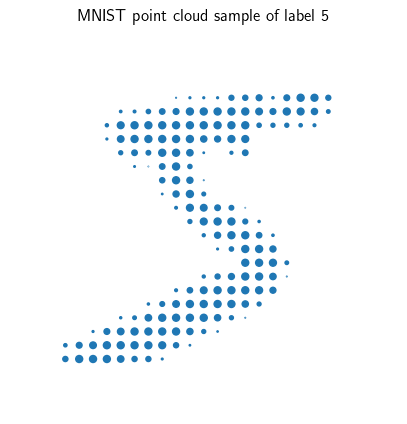

In [3]:
dataset = loader.load()
plot_point_cloud(dataset[0])

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. For this example the KNN lifting [[1]](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.KNNGraph.html) was chosen. The algorithm will add __K__ nearest neighbors to each node as edges to the graph.
***
[[1]](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.KNNGraph.html) KNN Graph conversion from Pytorch Geometric Documentation.
***
Similarly to before, we can specify the transformation we want to apply through its type and id --the correxponding config files located at `/configs/transforms`. 

Note that the *tranform_config* dictionary generated below can contain a sequence of tranforms if it is needed.

This can also be used to explore liftings from one topological domain to another, for example using two liftings it is possible to achieve a sequence such as: graph -> cell complex -> hypergraph. 

In [4]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "pointcloud2graph/knn_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for pointcloud2graph/knn_lifting:

{'transform_type': 'lifting',
 'transform_name': 'GraphKNNLifting',
 'k_value': 5,
 'loop': True,
 'feature_lifting': 'ProjectionSum'}


In [5]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)

Transform parameters are the same, using existing data_dir: /home/jinh/icml24/challenge-icml-2024/datasets/point_cloud/MNIST/MNIST/lifting/1120466020


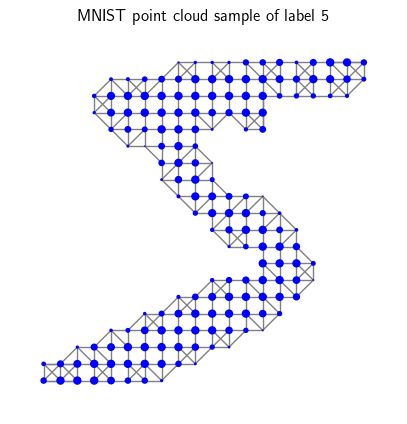

In [6]:
plot_point_cloud(lifted_dataset[0])

## Create and Run a Graph NN Model

In this section a simple GNN model is created to test that the used lifting works as intended. 

__NOTE__: there is no graph model in TopoModelX, so we will use a simple GNN model from PyTorch Geometric.

In [7]:
from modules.models.graph.gcn import GCNModel

model_type = "graph"
model_id = "gcn"
model_config = load_model_config(model_type, model_id)

model = GCNModel(model_config, dataset_config)


Model configuration for graph GCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [8]:
y_hat = model(lifted_dataset[0])
y_hat

tensor([[-81.3125,  43.9570,  22.4589, -10.4268,  36.8797,  44.4741, -71.3005,
          46.4742, -36.4946, -38.8048]], grad_fn=<MeanBackward1>)

If everything is correct the cell above should execute without errors. 